# Part I: Dataset loading & preprocessing

In [ ]:
!rm -rf /content/drive/MyDrive/cv_hw2_data

In [ ]:
!wget -c https://rgbd-dataset.cs.washington.edu/dataset/rgbd-dataset/rgbd-dataset.tar
!tar -xf rgbd-dataset.tar
!rm rgbd-dataset.tar

--2024-05-28 12:03:03--  https://rgbd-dataset.cs.washington.edu/dataset/rgbd-dataset/rgbd-dataset.tar
Resolving rgbd-dataset.cs.washington.edu (rgbd-dataset.cs.washington.edu)... 128.208.3.117, 2607:4000:200:12:3eec:efff:fe5e:6f68
Connecting to rgbd-dataset.cs.washington.edu (rgbd-dataset.cs.washington.edu)|128.208.3.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5067799243 (4.7G) [application/x-tar]
Saving to: ‘rgbd-dataset.tar’

rgbd-dataset.tar    100%[===================>]   4.72G  19.4MB/s    in 2m 53s  

2024-05-28 12:05:56 (28.0 MB/s) - ‘rgbd-dataset.tar’ saved [5067799243/5067799243]



In [ ]:
import os
import cv2
import shutil
import random
import matplotlib.pyplot as plt

def create_dataset(src_folder, dest_folder, selected_categories, image_size=(224, 224)):
    # Ensure the destination folder exists
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for category in selected_categories:
        # Source folder for the first instance of the category
        obj_folder = os.path.join(src_folder, category, f"{category}_1")
        dest_category_folder = os.path.join(dest_folder, category)

        # Ensure the destination category folder exists
        if not os.path.exists(dest_category_folder):
            os.makedirs(dest_category_folder)

        for filename in os.listdir(obj_folder):
            # Process only the cropped RGB images
            if filename.endswith('_crop.png'):
                img_path = os.path.join(obj_folder, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    # Resize the image to a fixed size if specified
                    if image_size:
                        img = cv2.resize(img, image_size)

                    # Save the loaded and resized image to the destination folder
                    dest_path = os.path.join(dest_category_folder, filename)
                    cv2.imwrite(dest_path, img)

# Function to display random images from each category
def display_random_images(dest_folder, selected_categories):
    plt.figure(figsize=(15, 10))

    for i, category in enumerate(selected_categories):
        category_folder = os.path.join(dest_folder, category)
        if os.path.exists(category_folder):
            images = [img for img in os.listdir(category_folder) if img.endswith('_crop.png')]
            if images:
                random_image = random.choice(images)
                img_path = os.path.join(category_folder, random_image)
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

                plt.subplot(2, 5, i+1)
                plt.imshow(img_rgb)
                plt.title(category)
                plt.axis('off')

    plt.tight_layout()
    plt.show()

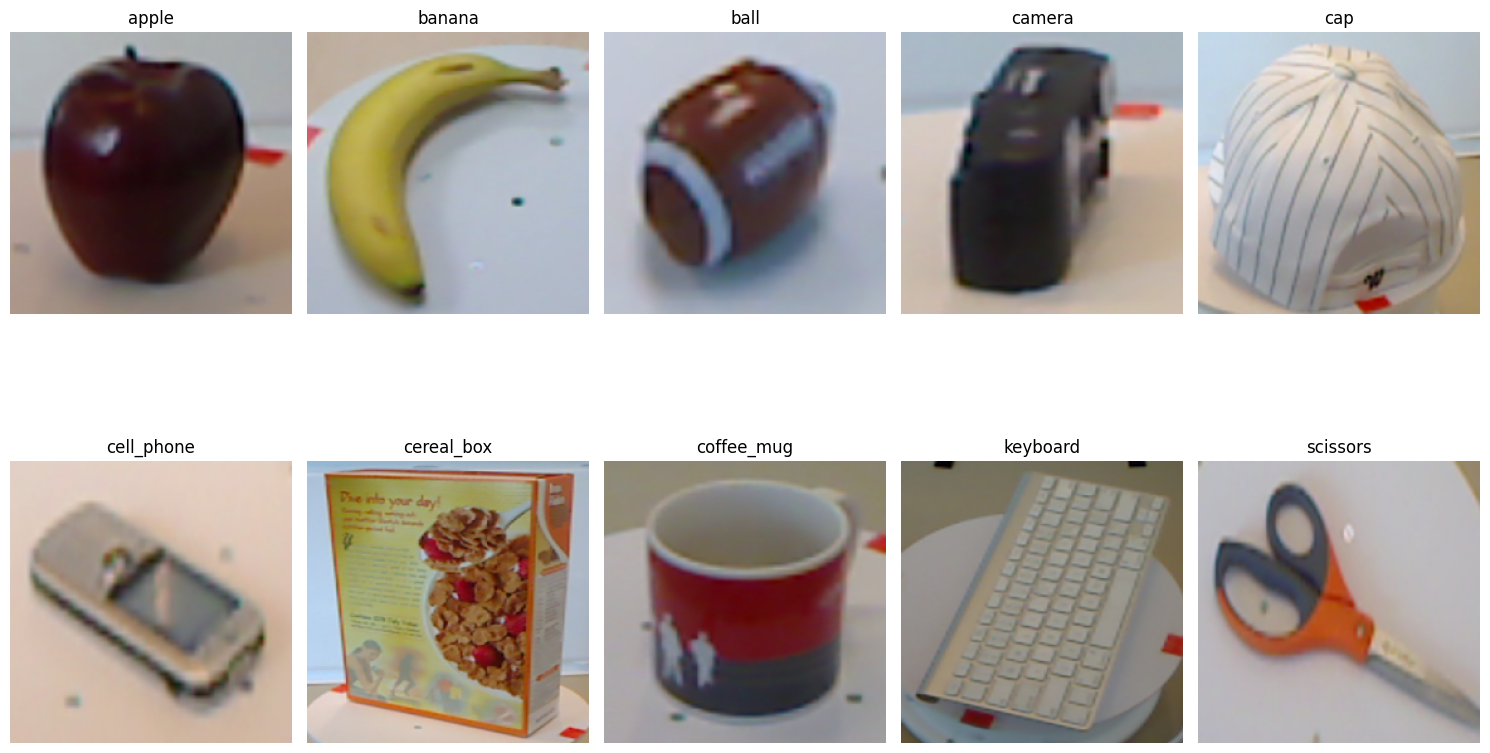

In [ ]:
src_folder = '/content/rgbd-dataset'
dest_folder = '/content/drive/MyDrive/cv_hw2_data'
selected_categories = ['apple', 'banana', 'ball', 'camera', 'cap', 'cell_phone', 'cereal_box', 'coffee_mug', 'keyboard', 'scissors']
create_dataset(src_folder, dest_folder, selected_categories)

# Display random images from each category
display_random_images(dest_folder, selected_categories)

# Part II: Object recognition based on feature detector and descriptor

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=100, method='SIFT'):
        self.n_clusters = n_clusters
        self.method = method
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.scaler = StandardScaler()
        self.detector = self.init_detector()

    def init_detector(self):
        if self.method == 'SIFT':
            return cv2.SIFT_create()
        elif self.method == 'ORB':
            return cv2.ORB_create()
        elif self.method == 'BRISK':
            return cv2.BRISK_create()
        else:
            raise ValueError(f"Unsupported method: {self.method}")

    def fit(self, X, y=None):
        features = self.extract_features(X)
        self.kmeans.fit(features)
        return self

    def transform(self, X):
        # Transform the images into histograms of visual words
        histograms = self.create_histograms(X)
        # Standardize the histograms
        return self.scaler.fit_transform(histograms)

    def extract_features(self, images):
        descriptors_list = []
        for img in images:
            if self.method == 'SIFT' or self.method == 'ORB' or self.method == 'BRISK':
                keypoints, descriptors = self.detector.detectAndCompute(img, None)
                if descriptors is not None:
                    descriptors_list.extend(descriptors)
            else:
                raise ValueError(f"Unsupported method: {self.method}")
        return np.array(descriptors_list)

    def create_histograms(self, images):
        histograms = []
        for img in images:
            if self.method == 'SIFT' or self.method == 'ORB' or self.method == 'BRISK':
                keypoints, descriptors = self.detector.detectAndCompute(img, None)
            else:
                raise ValueError(f"Unsupported method: {self.method}")
            if descriptors is not None:
                # Predict the cluster for each descriptor and create a histogram
                histogram = np.zeros(self.n_clusters)
                cluster_result = self.kmeans.predict(descriptors)
                for i in cluster_result:
                    histogram[i] += 1
                histograms.append(histogram)
            else:
                histograms.append(np.zeros(self.n_clusters))
        return np.array(histograms)

In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split

def load_dataset(folder, n_samples=100, seed=42):
    images = []
    labels = []

    random.seed(seed)

    for obj in os.listdir(folder):
        obj_folder = os.path.join(folder, obj)
        # Randomly select images from the current directory
        filenames = os.listdir(obj_folder)
        random.shuffle(filenames)
        for filename in filenames[:n_samples]:
            img_path = os.path.join(obj_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(obj)
    return np.array(images), np.array(labels)

In [ ]:
dataset_folder = '/content/drive/MyDrive/cv_hw2_data'
selected_categories = ['apple', 'banana', 'ball', 'camera', 'cap', 'cell_phone', 'cereal_box', 'coffee_mug', 'keyboard', 'scissors']

images, labels = load_dataset(dataset_folder, n_samples=200)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels, random_state=42)

Accuracy using SIFT: 0.95


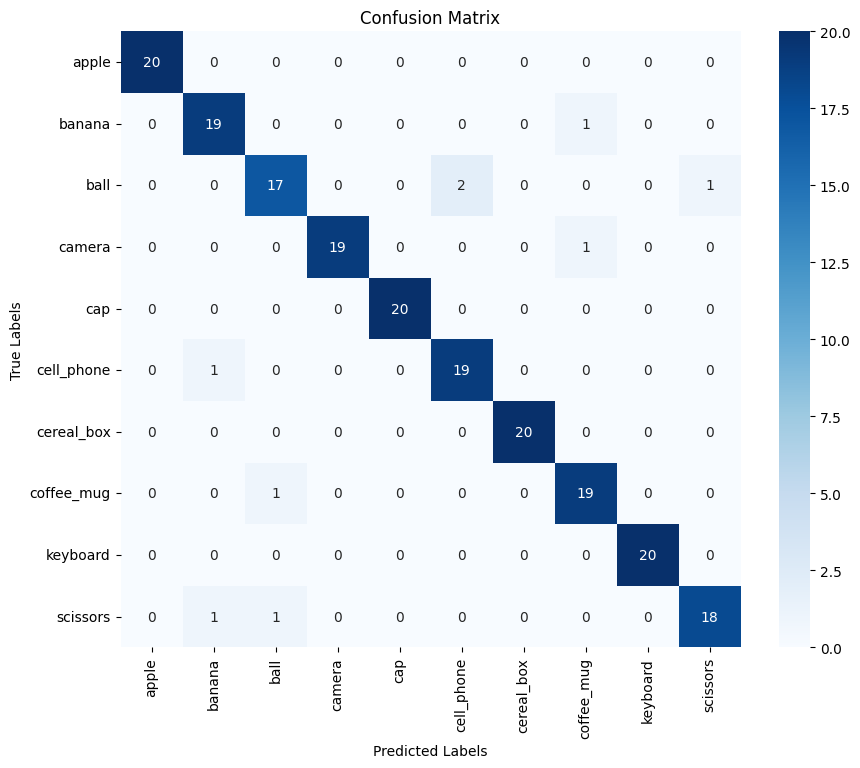

Accuracy using ORB: 0.92


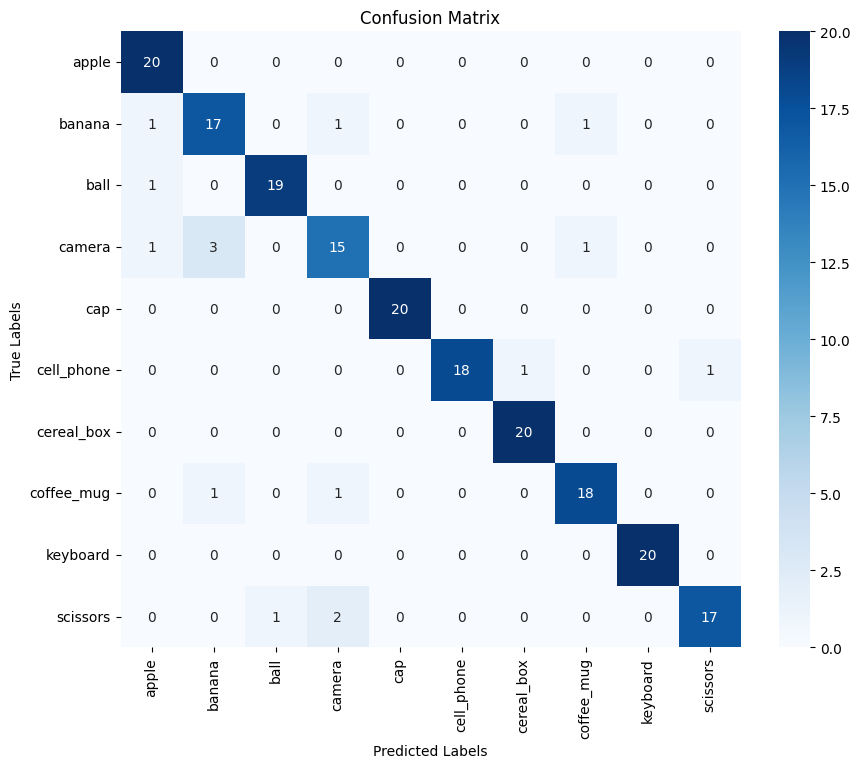

Accuracy using BRISK: 0.79


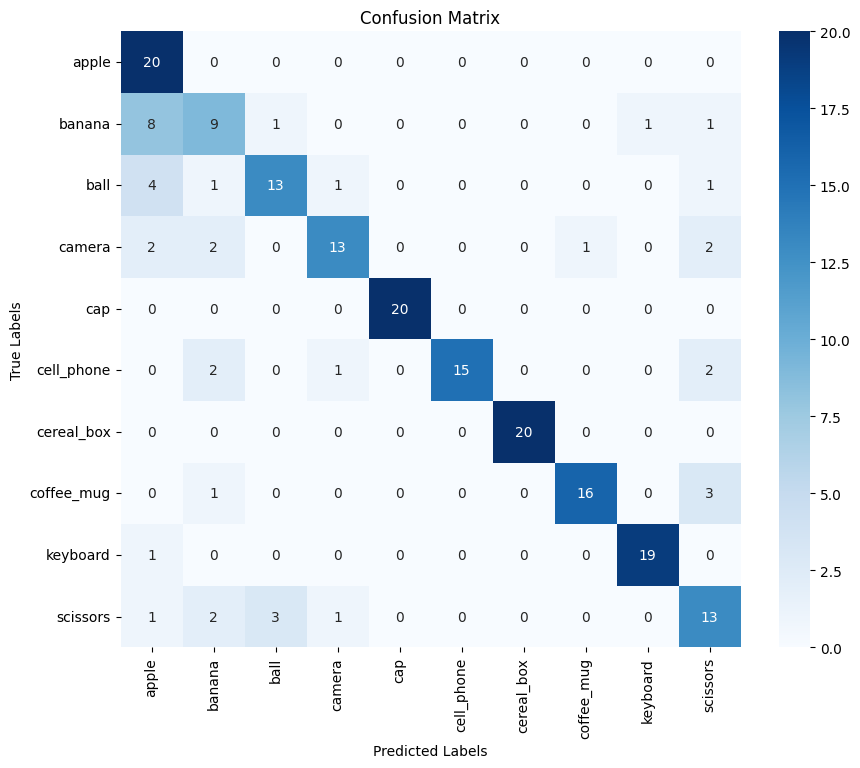

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred, categories):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Train and evaluate the classifier for each feature extraction method
methods = ['SIFT', 'ORB', 'BRISK']

# Loop through each feature extraction method
for method in methods:
    # Create a pipeline with FeatureExtractor and SVM classifier
    # FeatureExtractor: extracts features from images using the specified method
    # SVC: SVM classifier with a linear kernel
    pipeline = make_pipeline(FeatureExtractor(method=method), SVC(kernel='linear'))

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict the labels for the test data
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy using {method}: {accuracy:.2f}")

    display_confusion_matrix(y_test, y_pred, selected_categories)